In [1474]:

%autoreload 2

In [1475]:
import boto3
import lambda_function_v2
import cv2
import utils
import matplotlib.pyplot as plot
import color_images as ci
import numpy as np

In [1476]:
abalone_template_contour, small_abalone_template_contour, quarter_template_contour = lambda_function_v2.get_template_contours(rescaled_image)

In [1477]:
is_deployed = False

In [1478]:
#imageName = "blue_bkground_data/2016-08-01 17_44_32.1A.jpg"
#imageName = "color_bkground_data/IMG_5709.JPG"
#imageName = "may_2017_data/IMG_7.01.JPG"
#imageName = "617_data/FrankPhotos/Glass_Beach_Memorial_Day_ - 1003_214.jpg"
imageName = "new_color_bkground_data/blue/Eric 12.jpg"
showResults=True

In [1479]:
image_full = cv2.imread(imageName, cv2.IMREAD_COLOR)
rescaled_image, scaled_rows, scaled_cols = lambda_function_v2.get_scaled_image(image_full)
#read the image
orig_cols = len(image_full[0]) 
orig_rows = len(image_full)

#if its vertical, flip it 90
if orig_cols < orig_rows:
    img = cv2.transpose(image_full)  
    img = cv2.flip(img, 0)
    image_full = img.copy()
    orig_cols = len(image_full[0])
    orig_rows = len(image_full)
    

In [1480]:
mean_color = utils.get_mean_background_color(image_full)
print("mean: {}".format(mean_color))
is_white_or_gray = mean_color[1] < 70
is_white_or_gray

mean: (32.2, 11.44, 230.93333333333334)


True

In [1481]:
#is_color_bkground = utils.is_color(rescaled_image)
#background_val_diff = utils.is_background_similar_color(rescaled_image)
quarter_width = 0.955

#all the work
thresh_val = 30
blur_window = 5
contour_color=(0,0,255)
is_ruler=False
use_gray_threshold=False
enclosing_contour=None
first_pass=False
is_small=False
use_adaptive=False
input_image = rescaled_image.copy()
input_image = rescaled_image.copy()
color_image, threshold_bw, color_img, mid_row = ci.get_image_with_color_mask(input_image, thresh_val, 
    blur_window, False, first_pass, is_ruler, use_adaptive)


H:186.0, S:145.0, V:144.5
H:73.5, S:95.0, V:195.5


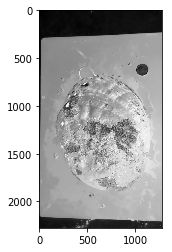

In [1482]:
copied = rescaled_image.copy()
denoised = cv2.fastNlMeansDenoisingColored(copied,None,10,10,7,21)

gray = cv2.cvtColor(denoised, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (5,5),0)
plot.imshow(blur, cmap=plot.cm.binary)


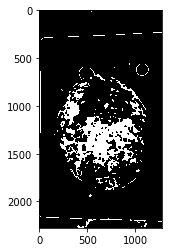

In [1483]:

if is_white_or_gray:
    lower_bound = 100
else:
    lower_bound = 20
    
edged_img = cv2.Canny(blur, lower_bound, 250,7) 
dilate_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11))
erode_kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(5,5))
kernel = np.ones((3,3), np.uint8)

edged_img = cv2.dilate(edged_img, kernel, iterations=4)

edged_img = cv2.morphologyEx(edged_img, cv2.MORPH_CLOSE, dilate_kernel)
#edged_img = cv2.morphologyEx(edged_img, cv2.MORPH_OPEN, erode_kernel)

#check this - seems like dark on white needs a cleanup, color needs an thickening
if is_white_or_gray:
    edged_img = cv2.erode(edged_img, erode_kernel, iterations=1)
else:
    edged_img = cv2.dilate(edged_img, kernel, iterations=2)
    
#do this if edges are continuos and huge
#erode_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9))
#edged_img = cv2.morphologyEx(edged_img, cv2.MORPH_OPEN, erode_kernel)
#edged_img = cv2.erode(edged_img, erode_kernel, iterations=3)
#

plot.imshow(edged_img, cmap='gray')

In [1484]:
#plot.imshow(threshold_bw)


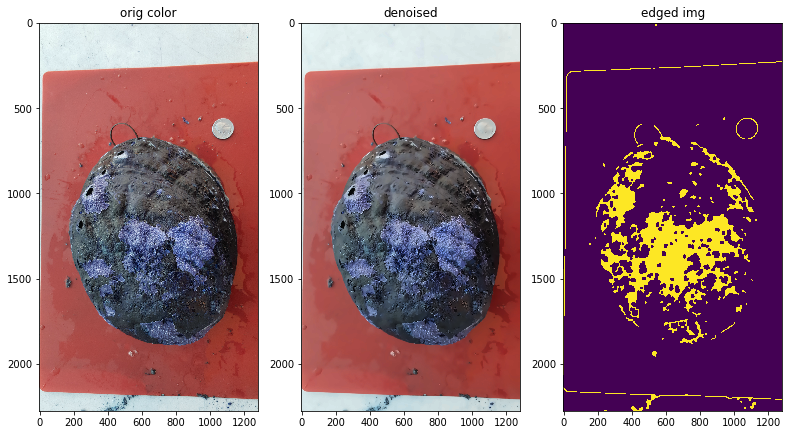

In [1485]:
#for thresh_val in thresholds:
# for blur in blurs:


#simplified find_edges
#edged = utils.find_edges(color_image, threshold_bw, True, False, 1, False)

images = [color_image, denoised, edged_img]
titles = ["orig color", "denoised", "edged img"]

cols = len(images)+1
n_images = len(images)
fig = plot.figure()
fig.nrows=1
fig.ncols=len(images)+1

for n, (image, title) in enumerate(zip(images, titles)):
    a = fig.add_subplot(1, cols, n + 1)
    plot.imshow(image)
    a.set_title(title)
fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
plot.show()

        #ci.do_color_image_match(input_image, template_contour, thresh_val, blur, 
        #    showImg, contour_color, is_ruler, use_gray_threshold, enclosing_contour, 
        #    first_pass=first_pass, use_adaptive=use_adaptive,small_img=is_small)


In [1488]:
#gray_denoised = cv2.cvtColor(edged_img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(edged_img.copy(), 127,255,0)
cnts = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
len(cnts)
largest = utils.get_largest_edges(cnts[1])
len(largest)

ncols = len(rescaled_image[0]) 
nrows = len(rescaled_image)
img_area = nrows*ncols
img_area

matches = []
cnt = 0

for contour in largest:
    perc = contour[0]/img_area
    target_contour = contour[1]
    print("{}".format(perc))
    
    if perc <= 0.75:
        break
        '''if cnt==0:
            tcont = target_contour
        else:
            cnt+=1
        hull = cv2.convexHull(target_contour)
        val = cv2.matchShapes(hull, abalone_template_contour, 2, 0.0)
        
        
        pair = [val, target_contour]
        dex=0
        for curr in matches:
            if curr[0] > val:
                dex+=1
            else:
                break
        matches.insert(dex, pair)
        '''
    else:
        print("skipping a contour...")
        
matches
contours = np.array(target_contour)

0.3881410300417399


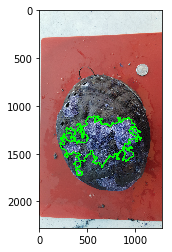

In [1489]:
#contours = largest[1][1]
cpy = rescaled_image.copy()
cv2.drawContours(cpy, contours,-1, (0,255,0),13)
plot.imshow(cpy)